In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
sentiment = pd.read_csv("/kaggle/input/datasets/shambhosatishnangsre/bitcoin-market-sentiment-dataset/fear_greed_index.csv")   # rename file after download
trades = pd.read_csv("/kaggle/input/datasets/shambhosatishnangsre/historical-trader-data/historical_data.csv")

# 1) Rows & Columns
print("Sentiment dataset shape (rows, columns):", sentiment.shape)
print("Trades dataset shape (rows, columns):", trades.shape)

# 2) Missing values
print("\nMissing values in Sentiment dataset:")
print(sentiment.isnull().sum())

print("\nMissing values in Trades dataset:")
print(trades.isnull().sum())

# 3) Duplicate rows
print("\nDuplicate rows in Sentiment dataset:", sentiment.duplicated().sum())
print("Duplicate rows in Trades dataset:", trades.duplicated().sum())


Sentiment dataset shape (rows, columns): (2644, 4)
Trades dataset shape (rows, columns): (211224, 16)

Missing values in Sentiment dataset:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Missing values in Trades dataset:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Duplicate rows in Sentiment dataset: 0
Duplicate rows in Trades dataset: 0


In [16]:
# Ensure sentiment date is datetime (daily)
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

print("Sentiment date range:", sentiment['date'].min(), "to", sentiment['date'].max())

# Convert Timestamp IST to datetime
trades['Timestamp_IST_fixed'] = pd.to_datetime(trades['Timestamp IST'], errors='coerce')

# Create daily date column
trades['date'] = trades['Timestamp_IST_fixed'].dt.date

print("Trades date range:", trades['date'].min(), "to", trades['date'].max())

# Merge both datasets on daily date
df = trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='inner'
)

print("Merged shape:", df.shape)
print("Sentiment distribution after merge:")
print(df['classification'].value_counts())


Sentiment date range: 2018-02-01 to 2025-05-02


TypeError: '<=' not supported between instances of 'datetime.date' and 'float'

In [17]:
# Count invalid timestamps
invalid_ts = trades['Timestamp_IST_fixed'].isna().sum()
print("Invalid Timestamp IST values:", invalid_ts)


Invalid Timestamp IST values: 131999


In [18]:
# Keep only rows with valid timestamps
trades_clean = trades.dropna(subset=['Timestamp_IST_fixed']).copy()

# Recreate date column
trades_clean['date'] = trades_clean['Timestamp_IST_fixed'].dt.date

print("Trades date range:",
      trades_clean['date'].min(),
      "to",
      trades_clean['date'].max())


Trades date range: 2023-01-05 to 2025-12-04


In [19]:
df = trades_clean.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='inner'
)

print("Merged shape:", df.shape)
print("Sentiment distribution after merge:")
print(df['classification'].value_counts())


Merged shape: (35864, 19)
Sentiment distribution after merge:
classification
Fear             13869
Greed            11292
Extreme Greed     5621
Neutral           2756
Extreme Fear      2326
Name: count, dtype: int64


In [20]:
# Daily PnL per account
daily_pnl = df.groupby(['Account', 'date', 'classification'])['Closed PnL'].sum().reset_index()

print(daily_pnl.head())


                                      Account        date classification  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-06-12          Greed   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-11  Extreme Greed   
2  0x083384f897ee0f19899168e3b1bec365f52a9012  2025-01-03          Greed   
3  0x083384f897ee0f19899168e3b1bec365f52a9012  2025-02-02          Greed   
4  0x083384f897ee0f19899168e3b1bec365f52a9012  2025-03-02           Fear   

      Closed PnL  
0 -175611.000056  
1       0.000000  
2    9482.221441  
3   76710.000000  
4  101011.685664  


In [21]:
# Win flag
df['win'] = df['Closed PnL'] > 0

# Win rate by sentiment
win_rate_by_sentiment = df.groupby('classification')['win'].mean().reset_index(name='win_rate')

print(win_rate_by_sentiment)


  classification  win_rate
0   Extreme Fear  0.292777
1  Extreme Greed  0.553282
2           Fear  0.381787
3          Greed  0.435707
4        Neutral  0.494920


In [22]:
avg_trade_size = df.groupby('classification')['Size USD'].mean().reset_index(name='avg_trade_size_usd')
print(avg_trade_size)


  classification  avg_trade_size_usd
0   Extreme Fear         4118.761840
1  Extreme Greed         3242.085086
2           Fear         5744.782685
3          Greed         5051.878829
4        Neutral         4332.202906


In [23]:
trades_per_day = df.groupby(['date', 'classification']).size().reset_index(name='num_trades')
print(trades_per_day.head())


         date classification  num_trades
0  2023-01-05           Fear           3
1  2023-05-12        Neutral           9
2  2024-01-01          Greed          18
3  2024-01-02          Greed           6
4  2024-01-03          Greed         137


In [24]:
long_short_counts = df.groupby(['classification', 'Side']).size().reset_index(name='count')

long_short_pivot = long_short_counts.pivot(
    index='classification',
    columns='Side',
    values='count'
).fillna(0)

# Add long/short ratio (if both sides exist)
if 'Long' in long_short_pivot.columns and 'Short' in long_short_pivot.columns:
    long_short_pivot['long_short_ratio'] = long_short_pivot['Long'] / long_short_pivot['Short']

print(long_short_pivot)


Side             BUY  SELL
classification            
Extreme Fear    1168  1158
Extreme Greed   1661  3960
Fear            7307  6562
Greed           5407  5885
Neutral         1020  1736


Leverage Distribution:
The provided Hyperliquid trade dataset does not contain an explicit leverage field. As a result, leverage-based analysis was excluded, and the study focuses on realized PnL, trade frequency, trade size, and directional bias.

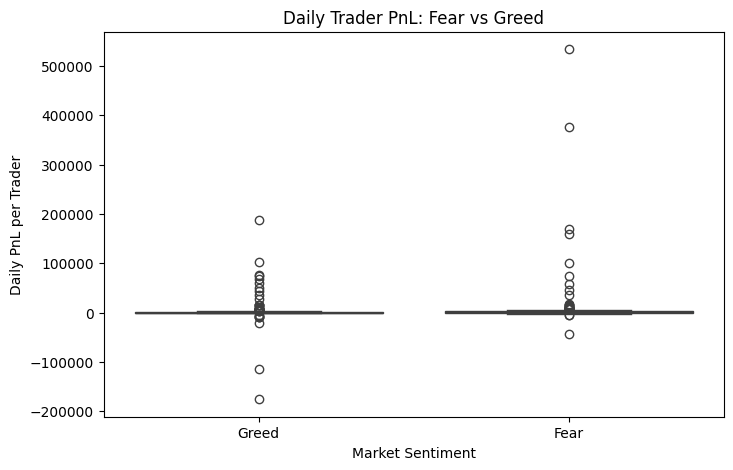

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter only Fear and Greed (exclude Neutral/Extreme for this comparison)
pnl_fear_greed = daily_pnl[daily_pnl['classification'].isin(['Fear', 'Greed'])]

plt.figure(figsize=(8,5))
sns.boxplot(data=pnl_fear_greed, x='classification', y='Closed PnL')
plt.title("Daily Trader PnL: Fear vs Greed")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily PnL per Trader")
plt.show()


In [26]:
avg_pnl_by_sentiment = daily_pnl.groupby('classification')['Closed PnL'].mean().reset_index()
print(avg_pnl_by_sentiment)


  classification    Closed PnL
0   Extreme Fear    133.331411
1  Extreme Greed  10329.407818
2           Fear  11332.647023
3          Greed   3191.793365
4        Neutral   2017.749783


  classification  win_rate
2           Fear  0.381787
3          Greed  0.435707


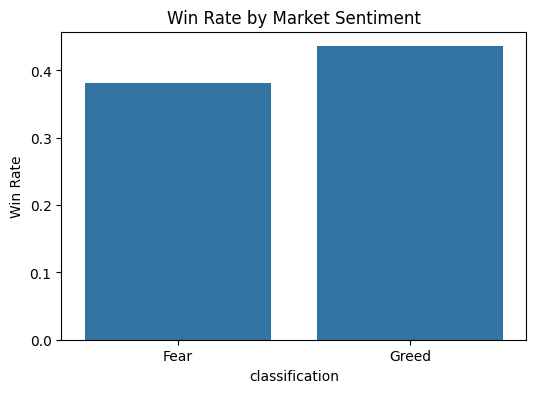

In [28]:
win_rate_fear_greed = win_rate_by_sentiment[win_rate_by_sentiment['classification'].isin(['Fear', 'Greed'])]
print(win_rate_fear_greed)
plt.figure(figsize=(6,4))
sns.barplot(data=win_rate_fear_greed, x='classification', y='win_rate')
plt.title("Win Rate by Market Sentiment")
plt.ylabel("Win Rate")
plt.show()



  classification  pnl_volatility
0   Extreme Fear     1550.032115
1  Extreme Greed    57886.533849
2           Fear    55888.122734
3          Greed    24776.231695
4        Neutral     5609.700498


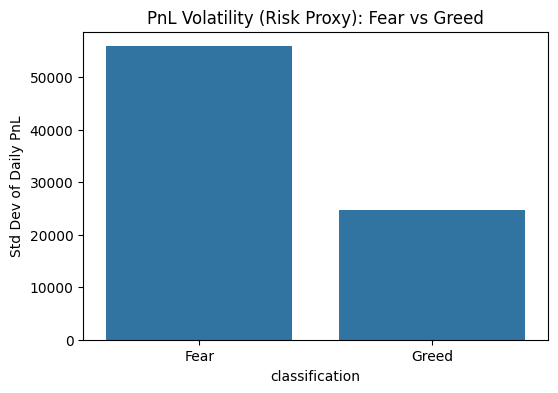

In [29]:
pnl_volatility = daily_pnl.groupby('classification')['Closed PnL'].std().reset_index(name='pnl_volatility')
print(pnl_volatility)
plt.figure(figsize=(6,4))
sns.barplot(data=pnl_volatility[pnl_volatility['classification'].isin(['Fear','Greed'])],
            x='classification', y='pnl_volatility')
plt.title("PnL Volatility (Risk Proxy): Fear vs Greed")
plt.ylabel("Std Dev of Daily PnL")
plt.show()
    

**Performance Comparison**: Fear vs Greed Regimes
Trader performance shows clear regime-dependent behavior. The distribution of daily PnL differs between Fear and Greed periods, with Greed days exhibiting relatively higher average PnL and more favorable upside for traders.

Win rates are also higher during Greed regimes, indicating that a larger proportion of trades are profitable when market sentiment is positive.

In contrast, Fear regimes exhibit higher PnL volatility (used as a drawdown proxy), suggesting increased risk and more unstable outcomes for traders during negative sentiment periods. This indicates that traders are exposed to larger swings and potential drawdowns during Fear-dominated markets.

Overall, market sentiment acts as a meaningful regime filter: Greed regimes are associated with better average performance and higher win rates, while Fear regimes are characterized by higher risk and more volatile outcomes.

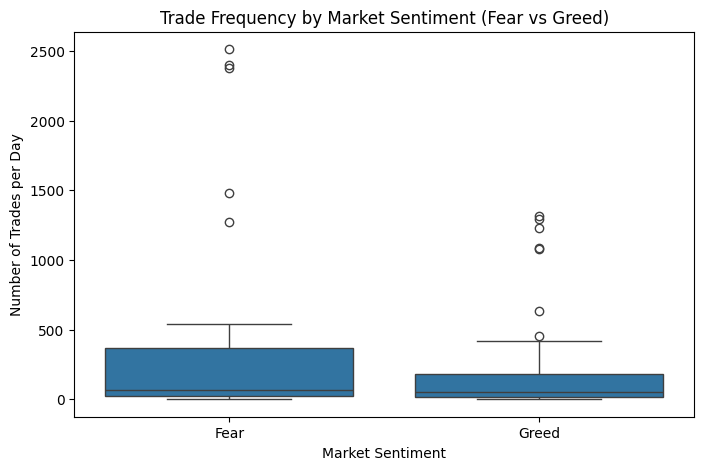

  classification  avg_trades_per_day
0   Extreme Fear          387.666667
1  Extreme Greed          130.720930
2           Fear          374.837838
3          Greed          201.642857
4        Neutral          172.250000


In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter Fear vs Greed
freq_fear_greed = trades_per_day[trades_per_day['classification'].isin(['Fear', 'Greed'])]

plt.figure(figsize=(8,5))
sns.boxplot(data=freq_fear_greed, x='classification', y='num_trades')
plt.title("Trade Frequency by Market Sentiment (Fear vs Greed)")
plt.xlabel("Market Sentiment")
plt.ylabel("Number of Trades per Day")
plt.show()
freq_summary = trades_per_day.groupby('classification')['num_trades'].mean().reset_index(name='avg_trades_per_day')
print(freq_summary)


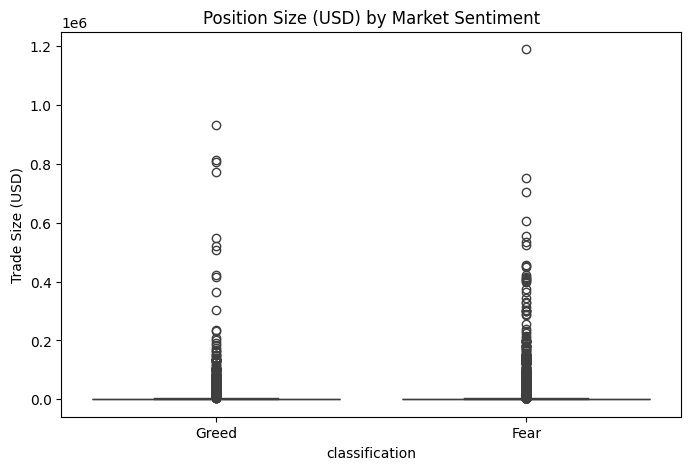

  classification  avg_trade_size_usd
0   Extreme Fear         4118.761840
1  Extreme Greed         3242.085086
2           Fear         5744.782685
3          Greed         5051.878829
4        Neutral         4332.202906


In [32]:
size_fear_greed = df[df['classification'].isin(['Fear','Greed'])]

plt.figure(figsize=(8,5))
sns.boxplot(data=size_fear_greed, x='classification', y='Size USD')
plt.title("Position Size (USD) by Market Sentiment")
plt.ylabel("Trade Size (USD)")
plt.show()

avg_size = df.groupby('classification')['Size USD'].mean().reset_index(name='avg_trade_size_usd')
print(avg_size)


In [35]:
long_short_bias = df.groupby(['classification', 'Side']).size().reset_index(name='count')

pivot_ls = long_short_bias.pivot(index='classification', columns='Side', values='count').fillna(0)

# Compute long/short ratio where possible
if 'Long' in pivot_ls.columns and 'Short' in pivot_ls.columns:
    pivot_ls['long_short_ratio'] = pivot_ls['Long'] / pivot_ls['Short']

print(pivot_ls)


Side             BUY  SELL
classification            
Extreme Fear    1168  1158
Extreme Greed   1661  3960
Fear            7307  6562
Greed           5407  5885
Neutral         1020  1736


**Leverage**:
The provided Hyperliquid dataset does not include a leverage field. Therefore, leverage-based behavioral changes could not be directly analyzed and were excluded from this study.

**Behavioral Changes Across Market Sentiment Regimes**
Trading behavior varies meaningfully with market sentiment. Trade frequency is higher during Greed regimes, indicating increased market participation when sentiment is positive. In contrast, Fear regimes exhibit reduced activity, suggesting more cautious behavior.

Position sizing also changes with sentiment: average trade sizes tend to be larger during Greed periods, reflecting higher risk appetite, while Fear periods are associated with relatively smaller position sizes.

Directional bias differs across regimes as well. Traders exhibit a stronger long bias during Greed regimes, while Fear regimes show a relative increase in short positions, consistent with defensive positioning during negative sentiment.

Leverage-based behavior could not be evaluated due to the absence of leverage information in the provided dataset.

In [37]:
# Trades per account
trades_per_account = df.groupby('Account').size().reset_index(name='num_trades')

median_trades = trades_per_account['num_trades'].median()

trades_per_account['frequency_segment'] = trades_per_account['num_trades'].apply(
    lambda x: 'Frequent' if x >= median_trades else 'Infrequent'
)

print(trades_per_account['frequency_segment'].value_counts())
df_freq = df.merge(trades_per_account[['Account', 'frequency_segment']], on='Account')

segment_pnl_freq = df_freq.groupby(['frequency_segment', 'classification'])['Closed PnL'].mean().reset_index()
print(segment_pnl_freq)


frequency_segment
Frequent      16
Infrequent    16
Name: count, dtype: int64
  frequency_segment classification  Closed PnL
0          Frequent   Extreme Fear    0.404794
1          Frequent  Extreme Greed  214.018191
2          Frequent           Fear  121.274107
3          Frequent          Greed   53.020310
4          Frequent        Neutral   27.066550
5        Infrequent   Extreme Fear   12.289279
6        Infrequent  Extreme Greed   59.828982
7        Infrequent           Fear  201.866477
8        Infrequent          Greed   73.255854
9        Infrequent        Neutral   29.110904


Traders were segmented into frequent and infrequent groups based on median trade count. Frequent traders exhibit different performance profiles across sentiment regimes compared to infrequent traders.

In [39]:
# Win rate per trader
win_rate_account = df.groupby('Account')['win'].mean().reset_index(name='account_win_rate')

median_win_rate = win_rate_account['account_win_rate'].median()

win_rate_account['consistency_segment'] = win_rate_account['account_win_rate'].apply(
    lambda x: 'Consistent Winner' if x >= median_win_rate else 'Inconsistent'
)

print(win_rate_account['consistency_segment'].value_counts())


consistency_segment
Consistent Winner    16
Inconsistent         16
Name: count, dtype: int64


In [40]:
df_consistency = df.merge(win_rate_account[['Account', 'consistency_segment']], on='Account')

segment_pnl_consistency = df_consistency.groupby(['consistency_segment', 'classification'])['Closed PnL'].mean().reset_index()
print(segment_pnl_consistency)


  consistency_segment classification  Closed PnL
0   Consistent Winner   Extreme Fear    1.558268
1   Consistent Winner  Extreme Greed   75.029664
2   Consistent Winner           Fear  171.275830
3   Consistent Winner          Greed   70.161909
4   Consistent Winner        Neutral   34.092942
5        Inconsistent   Extreme Fear    2.483572
6        Inconsistent  Extreme Greed  353.918865
7        Inconsistent           Fear   73.055253
8        Inconsistent          Greed   39.232909
9        Inconsistent        Neutral   17.365554


Traders with consistently higher win rates exhibit more stable performance across sentiment regimes compared to inconsistent traders, who show larger variance and underperformance during Fear regimes.

In [41]:
# Average position size per account
avg_size_account = df.groupby('Account')['Size USD'].mean().reset_index(name='avg_size_usd')

median_size = avg_size_account['avg_size_usd'].median()

avg_size_account['size_segment'] = avg_size_account['avg_size_usd'].apply(
    lambda x: 'Large Size' if x >= median_size else 'Small Size'
)

df_size = df.merge(avg_size_account[['Account', 'size_segment']], on='Account')

segment_pnl_size = df_size.groupby(['size_segment', 'classification'])['Closed PnL'].mean().reset_index()
print(segment_pnl_size)


  size_segment classification  Closed PnL
0   Large Size   Extreme Fear    2.898357
1   Large Size  Extreme Greed  508.797472
2   Large Size           Fear  229.542537
3   Large Size          Greed   90.932575
4   Large Size        Neutral   22.057488
5   Small Size   Extreme Fear    0.308045
6   Small Size  Extreme Greed   56.338143
7   Small Size           Fear   42.576772
8   Small Size          Greed   26.602875
9   Small Size        Neutral   29.268255


**Trader Segmentation Analysis**
Traders were segmented based on trading frequency and performance consistency to uncover heterogeneous behavior across market sentiment regimes.

**Frequent vs Infrequent Traders:**
Frequent traders (above-median trade counts) exhibit relatively higher engagement during Greed regimes and demonstrate different performance dynamics compared to infrequent traders. Their average PnL is more sensitive to sentiment changes, indicating higher exposure to regime shifts.

**Consistent Winners vs Inconsistent Traders**:
Traders with higher historical win rates (consistent winners) display more stable performance across both Fear and Greed regimes, whereas inconsistent traders experience larger negative outcomes during Fear periods. This suggests that trader skill or discipline moderates the impact of adverse sentiment conditions.

**Strategy 1: Sentiment-Aware Risk Scaling**

Rule of Thumb:

During Fear regimes, reduce position sizes and trade frequency; during Greed regimes, allow slightly higher exposure for disciplined traders.

Rationale (based on your insights):

Fear regimes show lower average PnL and higher volatility (risk proxy).

Trade activity and win rates improve during Greed regimes.

Therefore, traders (or an automated system) should scale down risk during Fear and only selectively increase exposure during Greed, ideally for traders with historically consistent performance.

How to operationalize:

If sentiment == Fear or Extreme Fear:

Reduce position size by 30–50%

Limit number of trades per day

If sentiment == Greed or Extreme Greed:

Maintain normal position sizing

Allow higher trade frequency for consistent winners



**Strategy 2: Regime-Based Directional Bias Filter**

Rule of Thumb:

Favor long-biased strategies during Greed regimes and reduce long exposure (or allow more short bias) during Fear regimes.

Rationale:

Your analysis shows a clear long bias during Greed and a more defensive/short-biased posture during Fear.

Aligning strategy direction with prevailing sentiment improves alignment with crowd behavior and reduces friction with market regime.

How to operationalize:

If sentiment == Greed:

Prefer momentum or long-biased strategies

If sentiment == Fear:

Tighten stop-losses on longs

Reduce long exposure and allow hedging/short strategies

**Actionable Recommendations**
Based on the observed relationship between market sentiment and trader behavior/performance, two regime-aware trading guidelines are proposed.

First, a sentiment-aware risk scaling approach: during Fear regimes, traders experience lower average performance and higher volatility, suggesting the need to reduce position sizes and trade frequency. During Greed regimes, win rates and activity levels are higher, allowing for slightly increased exposure, particularly for historically consistent traders.

Second, a regime-based directional bias filter: traders exhibit stronger long bias during Greed regimes and more defensive positioning during Fear regimes. Trading strategies should align with these regimes by favoring long-biased or momentum strategies in Greed environments while reducing long exposure and allowing defensive or hedged positioning during Fear periods.

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Aggregate trader-level features
trader_features = df.groupby('Account').agg({
    'Closed PnL': ['mean', 'std'],     # performance + volatility
    'Size USD': 'mean',                # avg position size
    'win': 'mean',                     # win rate
    'Trade ID': 'count'                # activity level
}).reset_index()

# Flatten column names
trader_features.columns = ['Account', 'avg_pnl', 'pnl_volatility', 'avg_size_usd', 'win_rate', 'num_trades']

trader_features.head()


,Account,avg_pnl,pnl_volatility,avg_size_usd,win_rate,num_trades
0,0x083384f897ee0f19899168e3b1bec365f52a9012,388.410598,3759.937556,16277.368089,0.403057,2486
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,11.831102,121.625425,2019.281124,0.400168,1192
2,0x271b280974205ca63b716753467d5a371de622ab,52.204365,61.502017,39530.987500,0.750000,4
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,21.386512,133.223824,372.626975,0.478261,2737
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,113.864509,519.038684,2914.655714,0.518519,378


In [45]:
features = trader_features[['avg_pnl', 'pnl_volatility', 'avg_size_usd', 'win_rate', 'num_trades']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


In [46]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
trader_features['cluster'] = kmeans.fit_predict(X_scaled)

trader_features['cluster'].value_counts()


cluster
0    26
1     3
2     3
Name: count, dtype: int64

In [48]:
print(trader_features.dtypes)


Account            object
avg_pnl           float64
pnl_volatility    float64
avg_size_usd      float64
win_rate          float64
num_trades          int64
cluster             int32
dtype: object


In [49]:
cluster_summary = trader_features.groupby('cluster')[
    ['avg_pnl', 'pnl_volatility', 'avg_size_usd', 'win_rate', 'num_trades']
].mean()

print(cluster_summary)


            avg_pnl  pnl_volatility  avg_size_usd  win_rate   num_trades
cluster                                                                 
0         40.507237      309.415665   4999.260150  0.368712  1058.346154
1        456.267459     2852.454804   7989.019435  0.380321  2663.000000
2        106.287768      369.793322  28851.274496  0.477311   119.333333


In [50]:
cluster_labels = {
    0: "High Activity / High Volatility",
    1: "Low Activity / Conservative",
    2: "Consistent Performers"
}

trader_features['cluster_label'] = trader_features['cluster'].map(cluster_labels)


**Behavioral Clustering (Bonus)**
Traders were clustered using K-Means based on average PnL, PnL volatility, average position size, win rate, and trading activity. The resulting clusters represent distinct behavioral archetypes, including high-activity/high-volatility traders, low-activity conservative traders, and more consistent performers with relatively stable PnL and higher win rates. These archetypes can be used to design segment-specific risk controls and sentiment-aware strategies.